### 畳み込みニューラルネットワーク (Convolutional Neural Network)

In [1]:
# データを読み込み
import pandas as pd
train = pd.read_csv('./data/mnist_train.csv')
test = pd.read_csv('./data/mnist_test.csv')

X_train = train.ix[:, 1:].values
y_train = train.ix[:, 0].values
X_test = test.values

In [2]:
import theano
from keras.utils import np_utils

# データ型を変換
theano.config.floatX = 'float32'

X_train = X_train.astype(theano.config.floatX)
X_test = X_test.astype(theano.config.floatX)

# 正規化
X_train /= 255
X_test /= 255

# one-hot エンコーディング
y_train_ohe = np_utils.to_categorical(y_train, num_classes=10)

Using TensorFlow backend.


In [3]:
from keras import backend as K
# theanoとtensorflowで受け付ける４次元配列の並びが違うので表示して確認
# print K.image_dim_ordering()

In [4]:
# 畳み込みニューラルネットでは、入力する画像の形状を保つためにデータを４次元配列に変換
# サンプルサイズ, 1画像の縦幅, 横幅, チャネル（白黒なら1）
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
# 第1層の引数に必要な画像サイズを定義
input_shape = (28, 28, 1)

In [5]:
# 重みを可視化
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def visualize_filter(model):
    # 最初の畳み込み層の重みを取得
    # tf => (nb_row, nb_col, nb_channel, nb_filter)
    # th => (nb_filter, nb_channel, nb_row, nb_col)
    W = model.layers[0].get_weights()[0]

    # 次元を並べ替え
    if K.image_dim_ordering() == 'tf':
        # (nb_filter, nb_channel, nb_row, nb_col)
        W = W.transpose(3, 2, 0, 1)

    nb_filter, nb_channel, nb_row, nb_col = W.shape
    
    # フィルタの重みを描画
    plt.figure()
    for i in range(nb_filter):
        # フィルタの画像
        im = W[i, 0]

        # 重みを0-255のスケールに変換
        scaler = MinMaxScaler(feature_range=(0, 255))
        im = scaler.fit_transform(im)

        plt.subplot(4, 8, i + 1)
        plt.axis('off')
        plt.imshow(im, cmap="gray")
    plt.show()

In [6]:
# cnn を定義
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping

# 各層のパラメータ
filters_1 = 20         # 第一層用畳み込みフィルタ数
filters_2 = 50         # 第二層用畳み込みフィルタ数
kernel_size = (5, 5)   # 畳み込みフィルタの縦横pixel数
pool_size = (2, 2)     # プーリングを行う範囲の縦横pixel数
hidden_neurons = 500   # 全結合層一層目のニューロン数
classes = 10           # 分類するクラス数
epochs = 50            # 最適化計算のループ回数

model = Sequential()

# 畳み込み層1
# Conv2Dレイヤーをモデルの第1層に使うときはキーワード引数input_shape （整数のタプル，サンプル軸を含まない）を指定
model.add(Conv2D(filters=filters_1, kernel_size=kernel_size, input_shape=input_shape))
model.add(Activation('tanh'))
# pooling層1
model.add(MaxPooling2D(pool_size=pool_size))

# 畳み込み層2
model.add(Conv2D(filters=filters_2, kernel_size=kernel_size, input_shape=input_shape))
model.add(Activation('tanh'))
# pooling層1
model.add(MaxPooling2D(pool_size=pool_size))

# dropout層(正則化的な効果があり、汎化性能を上げることができる)
model.add(Dropout(0.2))

# 全結合層入力のため、１次元配列に変換
model.add(Flatten())

# 全結合層1
model.add(Dense(hidden_neurons))
model.add(Activation('tanh'))

# dropout層
#model.add(Dropout(0.5))

# 全結合層2
model.add(Dense(classes))
model.add(Activation("softmax"))

In [7]:
# モデルを可視化
# ShapeのNoneは任意の正の整数を期待することを意味する
# (任意のサンプル数, 縦のサイズ, 横のサイズ, フィルタ数)
# Paramはチューニング対象となるパラメータの数（畳み込み層ではフィルタ）
# 畳み込み層では フィルタ数×フィルタの縦ピクセル数×横ピクセル数+フィルタ数（=バイアス項を示す）
# 全入力層では、入力数×ニューロン数+ニューロン数（=バイアス項を示す）
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 20)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 50)          25050     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 50)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 50)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 50)          0         
__________

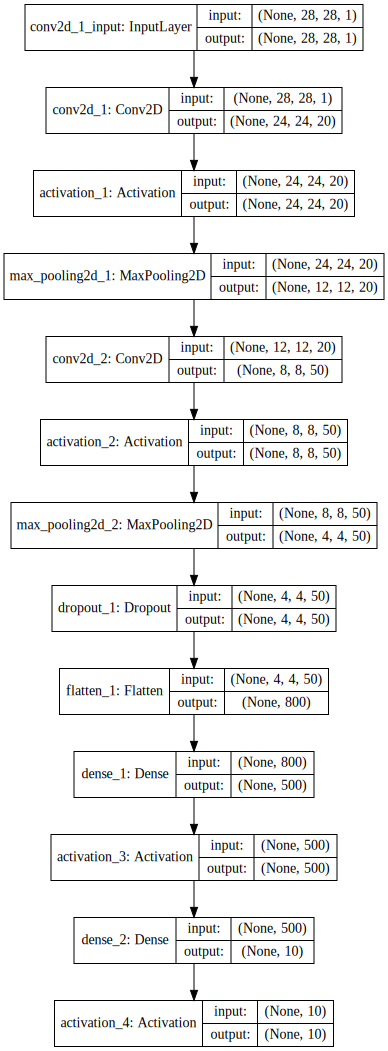

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [9]:
# モデルをコンパイル
# loss - 損失関数 = 目的関数（この関数の値が小さくなるように学習していく）
# 参考) https://keras.io/ja/objectives/
# optimizer - 最適化の手法
# 参考) https://keras.io/ja/optimizers/
# metrics - 評価関数
# 参考) https://keras.io/ja/metrics/
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

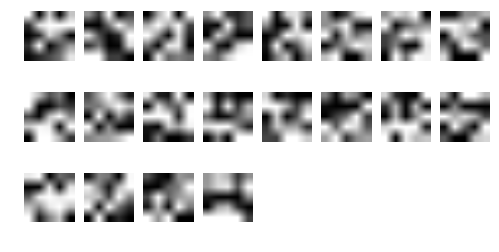

In [10]:
# 学習前の重みを表示
visualize_filter(model)

In [11]:
# モデルの学習
# 過学習を防ぐために収束判定を自動で行ってくれるのが、early stopping関数
# 評価用データを用いた最適化計算が収束したら予測精度が下がる前に計算ループを止めてくれる
# patientce：何回連続で損失の最小値が更新されなかったらループを止めるか
# verbose：コマンドラインにコメントを出力する場合は"1"と設定
early_stopping = EarlyStopping(patience=2, verbose=1)

# batch_size：計算効率化のために分割された訓練データの１グループあたりのデータ数
# validation_split：全ての画像の内、評価画像として用いる割合（0.2なら最後の20％）
model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping])

Train on 33600 samples, validate on 8400 samples
Epoch 1/50
33600/33600 [==============================] - 29s - loss: 0.3596 - acc: 0.8986 - val_loss: 0.1396 - val_acc: 0.9594
Epoch 2/50
33600/33600 [==============================] - 38s - loss: 0.1205 - acc: 0.9642 - val_loss: 0.0871 - val_acc: 0.9733
Epoch 3/50
33600/33600 [==============================] - 44s - loss: 0.0873 - acc: 0.9732 - val_loss: 0.0687 - val_acc: 0.9776
Epoch 4/50
33600/33600 [==============================] - 45s - loss: 0.0693 - acc: 0.9793 - val_loss: 0.0687 - val_acc: 0.9792
Epoch 5/50
33600/33600 [==============================] - 47s - loss: 0.0587 - acc: 0.9827 - val_loss: 0.0532 - val_acc: 0.9827
Epoch 6/50
33600/33600 [==============================] - 49s - loss: 0.0505 - acc: 0.9846 - val_loss: 0.0506 - val_acc: 0.9839
Epoch 7/50
33600/33600 [==============================] - 52s - loss: 0.0437 - acc: 0.9867 - val_loss: 0.0531 - val_acc: 0.9835
Epoch 8/50
33600/33600 [==============================]

In [12]:
# 結果を保存
submission = pd.DataFrame({
        'ImageId': test.index.values + 1,
        'Label': model.predict_classes(X_test, verbose=True).astype(int)
    })
submission.to_csv('result/predict_nn.csv', index=False)

27904/28000 [============================>.] - ETA: 0s

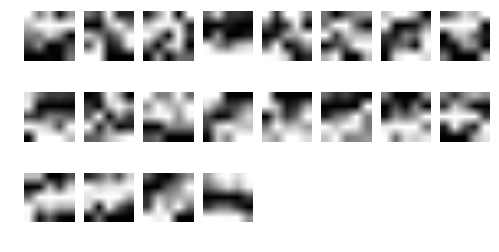

In [13]:
# 学習後の重みを表示
visualize_filter(model)